In [74]:
#I am making too many assumptions and guesses. Please go back and compare with original code

In [75]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [76]:
import kornia.augmentation as aug
random_shift = nn.Sequential(aug.RandomCrop((80, 80)), nn.ReplicationPad2d(4), aug.RandomCrop((84, 84)))
aug = random_shift

In [77]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [78]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [79]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Computing Temporal Difference Loss</h2>

In [80]:
class Agent():
    def __init__(self):
        self.model = CnnDQN(env.observation_space.shape, env.action_space.n)
        self.momentum_net = CnnDQN(env.observation_space.shape, env.action_space.n)
        self.initialize_momentum_net()
        if USE_CUDA:
            self.model = self.model.cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.00001)
    def compute_td_loss(self,batch_size):
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)
        state      = Variable(torch.FloatTensor(np.float32(state)))
        next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
        action     = Variable(torch.LongTensor(action))
        reward     = Variable(torch.FloatTensor(reward))
        done       = Variable(torch.FloatTensor(done))
        aug_states_1 = aug(states)
        aug_states_2 = aug(states)
        _, z_anch = CnnDQN(aug_states_1, env.action_space.n)
        _, z_target = momentumDQN(aug_states_1, env.action_space.n)
        z_proj = torch.matmul(CnnDQN.W, z_target.T)
        logits = torch.matmul(z_anch, z_proj)
        logits = (logits - torch.max(logits, 1)[0][:, None])
        logits = logits * 0.1
        labels = torch.arange(logits.shape[0]).long()
        moco_loss = (nn.CrossEntropyLoss()(logits, labels))
        
  #  def compute_td_loss(self,batch_size):
        #state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        state      = Variable(torch.FloatTensor(np.float32(state)))
        next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
        action     = Variable(torch.LongTensor(action))
        reward     = Variable(torch.FloatTensor(reward))
        done       = Variable(torch.FloatTensor(done))

        q_values      = self.model(state)
        next_q_values = self.model(next_state)

        q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value     = next_q_values.max(1)[0]
        expected_q_value = reward + gamma * next_q_value * (1 - done)

        loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        loss = loss + (moco_loss * 0.01)
        curl_loss = loss.mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        

        return loss
    def initialize_momentum_net(self):
        for param_q, param_k in zip(self.model.parameters(), self.momentum_net.parameters()):
            param_k.data.copy_(param_q.data) # update
            param_k.requires_grad = False  # not update by gradient
            
    # Code for this function from https://github.com/facebookresearch/moco
    @torch.no_grad()
    def update_momentum_net(self, momentum=0.999):
        for param_q, param_k in zip(self.model.parameters(), self.momentum_net.parameters()):
            param_k.data.copy_(momentum * param_k.data + (1.- momentum) * param_q.data)

In [81]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h1>Atari Environment</h1>

In [82]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [83]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [84]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.W_h = nn.Parameter(torch.rand(self.conv_output_size, args.hidden_size))
        self.W_c = nn.Parameter(torch.rand(args.hidden_size, 128))
        self.b_h = nn.Parameter(torch.zeros(args.hidden_size))
        self.b_c = nn.Parameter(torch.zeros(128))
        self.W = nn.Parameter(torch.rand(128, 128))
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        h = torch.matmul(x, self.W_h)+self.b_h
        h = nn.LayerNorm(h.shape[1])(h)
        h = F.relu(h)
        h = torch.matmul(h, self.W_c)+self.b_c
        h = nn.LayerNorm(128)(h)
        return x, h
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [85]:
replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [86]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

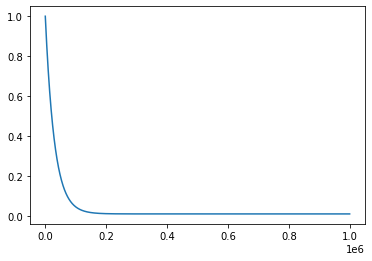

In [87]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

In [88]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()

dqn = Agent()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = dqn.model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = dqn.compute_td_loss(batch_size)
        dqn.update_momentum_net()
        losses.append(loss.data)
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)

ModuleAttributeError: 'CnnDQN' object has no attribute 'conv_output_size'